<a href="https://colab.research.google.com/github/shreyas1209/Sudoku_Solver_App/blob/main/Sudoku_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn.functional as F
import time 
import random
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torchvision.utils as vutils

In [2]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [5]:
X = ((X-np.mean(X))/(np.std(X)))
X = X.reshape(X.shape[0],1,28,28)


In [6]:
X = X.astype('float32')
y = np.int_(y)


In [7]:
X = torch.tensor(X)
y = torch.tensor(y)
y = y.type(torch.LongTensor)

In [8]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.33, random_state=42)
print(X_train.dtype)



torch.float32


In [9]:
train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)

In [10]:
batchsize = 64
train_dataloader = DataLoader(dataset=train_dataset,batch_size = batchsize)
val_dataloader = DataLoader(dataset=val_dataset,batch_size = batchsize)

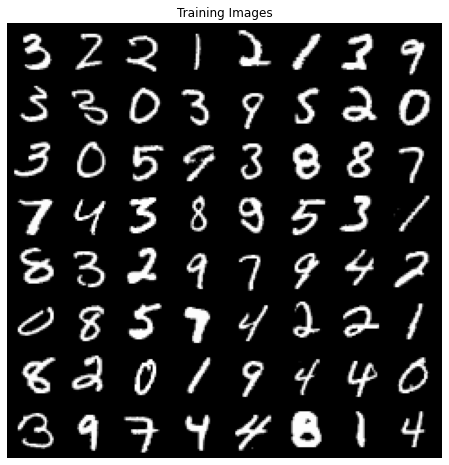

In [11]:
#plotting the images
train_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0][:64], padding=2, normalize=True),(1,2,0)))


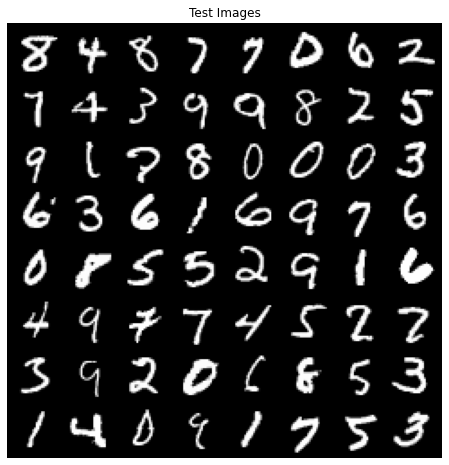

In [12]:
#plotting a set of  val images
val_batch = next(iter(val_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(val_batch[0][:64], padding=2, normalize=True),(1,2,0)))

In [13]:
def check_accuracy(model,dataloader):
  num_correct = 0
  num_samples = 0
  model.eval()
  model = model.to(device)
  
  with torch.no_grad():
    for DATA  in dataloader:
      data = DATA[0]
      data = data.to(device)
      classes = DATA[1]
      classes = classes.to(device)
      scores = model(data)
      predictions = scores.argmax(1)
      num_correct += sum((predictions == classes))
      num_samples += predictions.size(0)

    return float(num_correct)/float(num_samples)


In [14]:
def train (model,loss_function,optimizer,train_dl,val_dl,epochs):
  if torch.cuda.is_available(): torch.cuda.empty_cache()
  model = model.to(device = device)
  history = {"train_accuracies": [], "val_accuracies": [], "loss":[]}

  for epoch in range (epochs):
    
    model.train()
    train_loss = 0
    start = time.time()

    for batch_no,DATA in enumerate(train_dl,0):
      data,classes = DATA
      optimizer.zero_grad()
      data = data.to(torch.float32)
      data = data.to(device)
      classes = classes.to(device)
      outputs = model(data)
      loss = loss_function(outputs,classes)
      loss.backward()
      optimizer.step()

      
      running_loss = loss.item()
    
    #getting the stats
    history['train_accuracies'].append(check_accuracy(model,train_dl))
    history['val_accuracies'].append(check_accuracy(model,val_dl))
    history['loss'].append(running_loss/(len(train_dl)))
    
    end = time.time()
    total_time = end-start

    #printing the stats
    print('Epoch ({}/{}),Training loss : {:.8f}, Time: {:.2f}, train_accuracy:{:.4f}, val_accuracy:{:.4f}'.format(
          epoch+1, epochs, history["loss"][-1], total_time, history["train_accuracies"][-1], history["val_accuracies"][-1]))

  return model, history

In [15]:
#importing the model

import sys

sys.path.append('/content/gdrive/MyDrive/Sudoku/Models')

In [16]:
from sudoku_net import *

In [17]:
epochs = 10
learning_rate = 1e-3

In [18]:
model  = sudokunet(output_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [19]:
start = time.time()
model,history = train(model = model,
                      loss_function=loss_fn,
                      optimizer = optimizer,
                      train_dl = train_dataloader,
                      val_dl = val_dataloader,
                      epochs = epochs)
end = time.time()
elapsed = end-start
print("Total time :", elapsed)

Epoch (1/10),Training loss : 0.00004233, Time: 3.36, train_accuracy:0.9841, val_accuracy:0.9802
Epoch (2/10),Training loss : 0.00000595, Time: 3.15, train_accuracy:0.9910, val_accuracy:0.9856
Epoch (3/10),Training loss : 0.00000681, Time: 3.12, train_accuracy:0.9919, val_accuracy:0.9853
Epoch (4/10),Training loss : 0.00000658, Time: 3.14, train_accuracy:0.9938, val_accuracy:0.9868
Epoch (5/10),Training loss : 0.00000542, Time: 3.12, train_accuracy:0.9942, val_accuracy:0.9865
Epoch (6/10),Training loss : 0.00000032, Time: 3.16, train_accuracy:0.9958, val_accuracy:0.9878
Epoch (7/10),Training loss : 0.00000244, Time: 3.18, train_accuracy:0.9966, val_accuracy:0.9879
Epoch (8/10),Training loss : 0.00000787, Time: 3.21, train_accuracy:0.9961, val_accuracy:0.9871
Epoch (9/10),Training loss : 0.00000040, Time: 3.20, train_accuracy:0.9956, val_accuracy:0.9860
Epoch (10/10),Training loss : 0.00000032, Time: 3.19, train_accuracy:0.9974, val_accuracy:0.9878
Total time : 42.31752347946167


In [20]:
torch.save(model.state_dict(), 'sudoku_weights.pth')

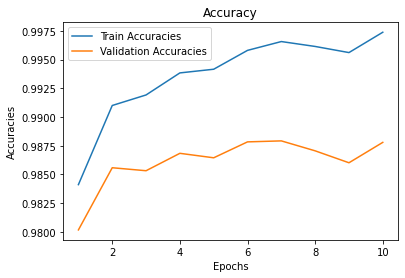

In [21]:
epoch_no = [(i+1) for i in range(epochs)]

plt.plot(epoch_no,history["train_accuracies"], label = 'Train Accuracies')
plt.plot(epoch_no,history["val_accuracies"], label = 'Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title('Accuracy')
plt.legend()
plt.show()


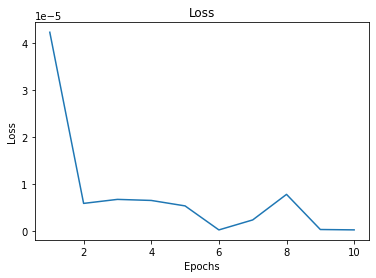

In [22]:
plt.plot(epoch_no,history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss')
plt.show()
